<a href="https://colab.research.google.com/github/daffaarazaan/testportogopay/blob/main/portogopay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 1️⃣ Install Kaggle and required libraries
!pip install -q kaggle xgboost==1.7.6 imbalanced-learn scikit-learn pandas matplotlib seaborn plotly streamlit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.3/200.3 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 110.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 109.4 MB/s eta 0:00:00


In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ealaxi/paysim1")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'paysim1' dataset.
Path to dataset files: /kaggle/input/paysim1


In [4]:
import os

# Should show the CSV file (something like PS_20174392719_1491204439457_log.csv)
os.listdir(path)


['PS_20174392719_1491204439457_log.csv']

In [5]:
import pandas as pd

# Replace with your actual filename if different
file_path = os.path.join(path, "PS_20174392719_1491204439457_log.csv")
df = pd.read_csv(file_path)

print("Shape:", df.shape)
df.head()


Shape: (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


#**STEP EDA**

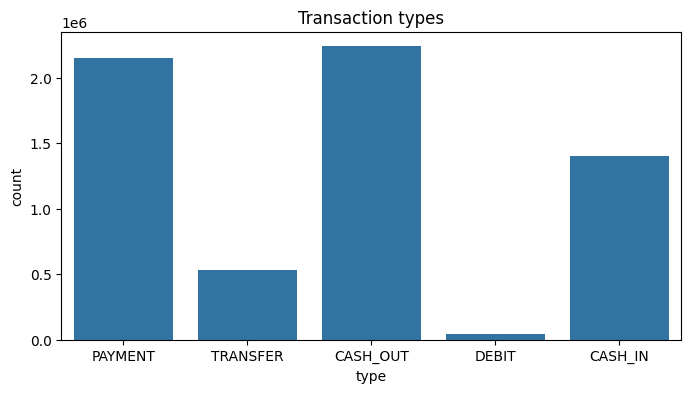

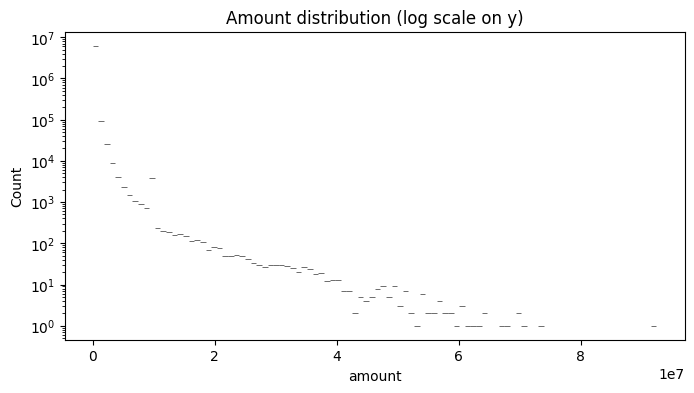

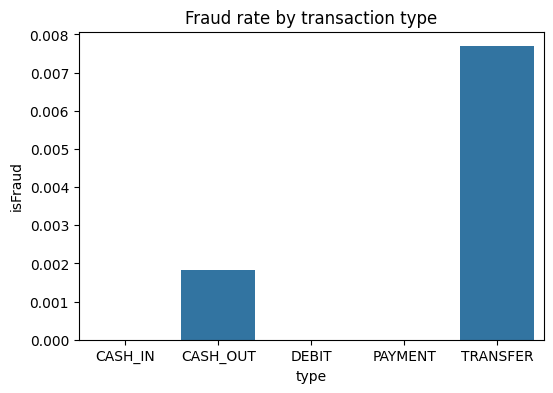

In [6]:
# Colab cell 3: EDA visuals
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.countplot(x='type', data=df)
plt.title('Transaction types')

plt.figure(figsize=(8,4))
sns.histplot(df['amount'], bins=100, log_scale=(False,True))
plt.title('Amount distribution (log scale on y)')

# Fraud by transaction type
plt.figure(figsize=(6,4))
sns.barplot(x='type', y='isFraud', data=df.groupby('type')['isFraud'].mean().reset_index())
plt.title('Fraud rate by transaction type')
plt.show()


#**STEP Feature Engineering**

In [7]:
import numpy as np

# Copy DataFrame
df_proc = df.copy()

# Log-transform amount to handle skewness
df_proc['amount_log'] = np.log1p(df_proc['amount'])

# Create delta (balance difference) features
df_proc['delta_org'] = df_proc['oldbalanceOrg'] - df_proc['newbalanceOrig']
df_proc['delta_dest'] = df_proc['oldbalanceDest'] - df_proc['newbalanceDest']

# Derive simulated hour from 'step' (PaySim's step ≈ 1 hour)
df_proc['hour_sim'] = df_proc['step'] % 24

# One-hot encode transaction type
df_proc = pd.get_dummies(df_proc, columns=['type'], prefix='type')

# Drop identifiers (not useful for modeling)
df_proc.drop(columns=['nameOrig', 'nameDest'], inplace=True)

# Preview new features
df_proc.head()


,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,amount_log,delta_org,delta_dest,hour_sim,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,9.194276,9839.64,0.0,1,False,False,False,True,False
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,7.531166,1864.28,0.0,1,False,False,False,True,False
2,1,181.00,181.0,0.00,0.0,0.0,1,0,5.204007,181.00,0.0,1,False,False,False,False,True
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,5.204007,181.00,21182.0,1,False,True,False,False,False
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,9.364703,11668.14,0.0,1,False,False,False,True,False


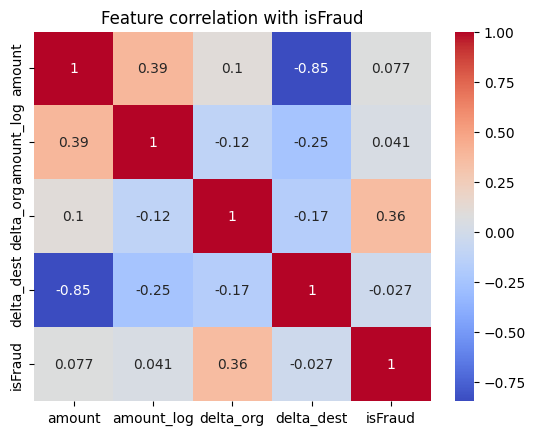

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_proc[['amount','amount_log','delta_org','delta_dest','isFraud']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Feature correlation with isFraud')
plt.show()


#**STEP 5**

In [9]:
# Step 5 — Chronological split
max_step = df_proc['step'].max()
split_step = int(max_step * 0.9)  # use 90% of time for train, last 10% for test

train = df_proc[df_proc['step'] <= split_step].reset_index(drop=True)
test  = df_proc[df_proc['step'] > split_step].reset_index(drop=True)

# Define target variable
y_train = train['isFraud']
y_test = test['isFraud']

# Drop unused target columns from features
X_train = train.drop(columns=['isFraud','isFlaggedFraud'])
X_test = test.drop(columns=['isFraud','isFlaggedFraud'])

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Fraud rate in train:", y_train.mean(), " | Fraud rate in test:", y_test.mean())


Train shape: (6293772, 15), Test shape: (68848, 15)
Fraud rate in train: 0.001170522224192424  | Fraud rate in test: 0.012287938647455263


#**STEP 6**

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import numpy as np

# Fill missing values just in case
X_train_filled = X_train.fillna(0)
X_test_filled  = X_test.fillna(0)

# Baseline model — use class_weight='balanced' to handle imbalance
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='saga', n_jobs=-1)
logreg.fit(X_train_filled, y_train)

# Predict probabilities
y_pred_proba_lr = logreg.predict_proba(X_test_filled)[:, 1]

# Evaluate
roc_auc = roc_auc_score(y_test, y_pred_proba_lr)
pr_auc  = average_precision_score(y_test, y_pred_proba_lr)

print(f"Baseline Logistic Regression → ROC-AUC: {roc_auc:.4f} | PR-AUC: {pr_auc:.4f}")

# Choose threshold (0.5) for quick look
y_pred_lr = (y_pred_proba_lr >= 0.5).astype(int)
print(classification_report(y_test, y_pred_lr, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Baseline Logistic Regression → ROC-AUC: 0.9818 | PR-AUC: 0.8026
              precision    recall  f1-score   support

           0     0.9997    0.8132    0.8968     68002
           1     0.0613    0.9799    0.1153       846

    accuracy                         0.8152     68848
   macro avg     0.5305    0.8965    0.5061     68848
weighted avg     0.9882    0.8152    0.8872     68848

Confusion Matrix:
 [[55298 12704]
 [   17   829]]


In [11]:
import xgboost as xgb

# Calculate imbalance ratio
pos = y_train.sum()
neg = len(y_train) - pos
scale_pos_weight = neg / pos
print("scale_pos_weight:", scale_pos_weight)

xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric='auc',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

xgb_clf.fit(X_train_filled, y_train,
            eval_set=[(X_test_filled, y_test)],
            verbose=False, early_stopping_rounds=10)

# Predict & evaluate
y_pred_proba_xgb = xgb_clf.predict_proba(X_test_filled)[:, 1]
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
pr_auc_xgb  = average_precision_score(y_test, y_pred_proba_xgb)

print(f"XGBoost → ROC-AUC: {roc_auc_xgb:.4f} | PR-AUC: {pr_auc_xgb:.4f}")


scale_pos_weight: 853.3195330528031


/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
/usr/local/lib/python3.12/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


XGBoost → ROC-AUC: 0.9999 | PR-AUC: 0.9936


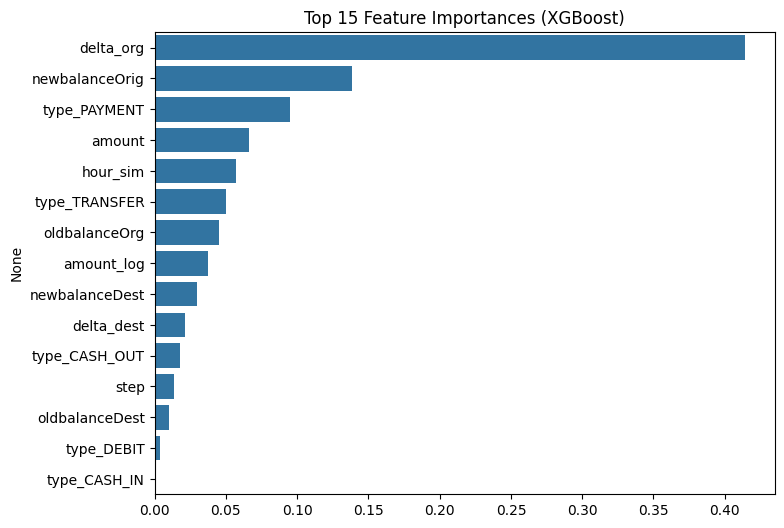

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

feat_imp = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
top_feat = feat_imp.sort_values(ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x=top_feat.values, y=top_feat.index)
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()


Precision@50: 1.000
Precision@100: 1.000
Precision@500: 1.000
Precision@1000: 0.846

Confusion matrix @0.9 threshold:
 [[67705   297]
 [    0   846]]


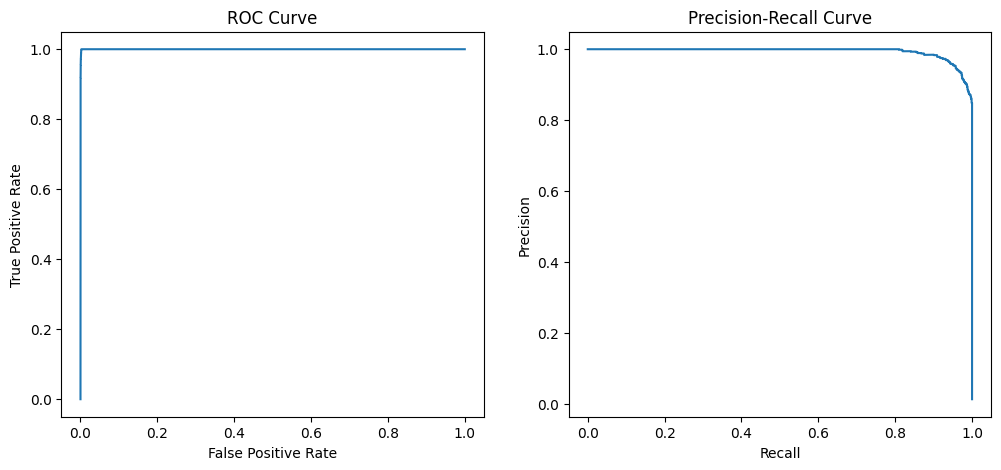

In [13]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

# Define function for precision@k
def precision_at_k(y_true, y_scores, k=100):
    """Fraction of true frauds among top k predicted scores."""
    threshold_index = np.argsort(y_scores)[-k:]
    return y_true.iloc[threshold_index].mean()

# Evaluate at several K levels
for k in [50, 100, 500, 1000]:
    p_at_k = precision_at_k(y_test, y_pred_proba_xgb, k)
    print(f"Precision@{k}: {p_at_k:.3f}")

# Try custom threshold (e.g., 0.9) for high recall
threshold = 0.9
y_pred_thresh = (y_pred_proba_xgb >= threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_thresh)
print("\nConfusion matrix @0.9 threshold:\n", cm)

# ROC & PR curves (optional visualization)
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
prec, rec, _ = precision_recall_curve(y_test, y_pred_proba_xgb)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

plt.subplot(1,2,2)
plt.plot(rec, prec)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


In [15]:
import joblib

# Save model
joblib.dump(xgb_clf, "xgb_fraud_model.joblib")

# Save feature columns for later prediction
import json
with open("model_features.json", "w") as f:
    json.dump(list(X_train.columns), f)

print("✅ Model and feature list saved!")


✅ Model and feature list saved!


In [18]:
import joblib

# Load the model
loaded_model = joblib.load("xgb_fraud_model.joblib")

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [19]:
import os

# List files in the current directory
print(os.listdir())

['.config', 'xgb_fraud_model.joblib', 'model_features.json', 'sample_data']


In [16]:
def predict_single_transaction(model, sample_row, columns):
    """Predict fraud probability for one transaction row."""
    x = sample_row.reindex(columns=columns, fill_value=0).values.reshape(1, -1)
    prob = model.predict_proba(x)[0, 1]
    return prob

# Test it
sample = X_test.sample(1, random_state=42)
prob = predict_single_transaction(xgb_clf, sample, X_train.columns)
print("Predicted fraud probability:", round(prob, 4))


Predicted fraud probability: 0.0003
